In [1]:
!pip install torchvision
!pip install torchinfo
!pip install torchmetrics
!pip install
!pip install wandb -qU

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
ERROR: You must give at least one requirement to install (see "pip help install")

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader, Dataset,WeightedRandomSampler,Subset
import torchvision.transforms as T
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import torchmetrics
from torchinfo import summary
import torchvision.models as models
%matplotlib inline

In [3]:
configs = {
    "experiment_name": "Baseline",
    "freeze_feature_extraction_layers": False,
    "pretrained":False,
    "efficientnet":False, # off-> Resnet18
    "data_augmentation":True,
    "transferlearning": False,

    # Data
    "img_dimensions" : (3,448,600),
    "batch_size" : 32,
    "num_classes" : 5,

    # CNN
    "filter_sizes" : [4,8,16],
    "kernel_size" : 5,
    "stride": 1,
    "padding":0,

    #Optimzation
    "learning_rate" : 0.001,
    "epochs" : 10,
    "weight_decay" : 0.00001,
    "patience" : 5
}

In [23]:
# Data Load


training_path = "Disease Grading/1. Original Images/a. Training Directory"
testing_path = "Disease Grading/1. Original Images/b. Testing Directory"

transform = transforms.Compose([
        transforms.RandomHorizontalFlip(0.5),
        transforms.Resize([448, 600]),
#         transforms.Pad((0, 20, 0, 20)),
        transforms.RandomRotation(20),
#         tranforms.WeightedRandomSampler()
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5944, 0.2908, 0.0962], std=[0.2047, 0.1284, 0.0866])
    ])
        
test_transform = transforms.Compose([
            transforms.Resize(([448, 600])),
            transforms.ToTensor()
            ])

train_dataset = torchvision.datasets.ImageFolder(training_path, transform = transform)
train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2])
test_dataset = torchvision.datasets.ImageFolder(testing_path, transform = test_transform)

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size = configs["batch_size"], shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size = configs["batch_size"], shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size = configs["batch_size"], shuffle=False)


labels_training = pd.read_csv("Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv")
labels_testing = pd.read_csv("Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv")
labels_training.dropna(axis = 1, inplace = True)

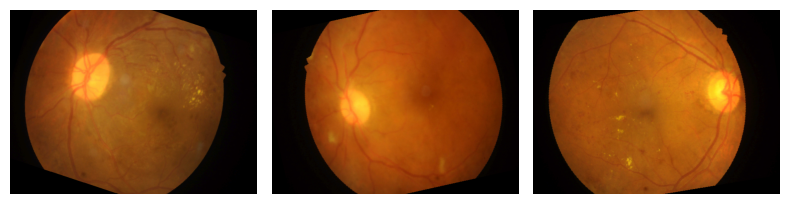

In [25]:
## Visualise transformations:
# Unnormalised Transform


import matplotlib.pyplot as plt
import torch
from torchvision import transforms


plt.figure(figsize=(8, 8))

iterator = iter(train_loader)
for i in range(3):
    plt.subplot(1, 3, i+1)
    image, _ = next(iterator)
    
    mean = torch.tensor([0.5944, 0.2908, 0.0962]).reshape(1, 1, 3)
    std = torch.tensor([0.2047, 0.1284, 0.0866]).reshape(1, 1, 3)
    
    image_unnormalized = (image[i].permute(1, 2, 0) * std + mean).clamp(0, 1)
    
    plt.imshow(image_unnormalized)
    plt.axis('off')

plt.tight_layout()
plt.show()

## CNN Hyper-parameter Sweeps

In [6]:
class CNN(nn.Module):
    def __init__(self, kernel_size, output_size):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            torch.nn.Conv2d(3, 4, kernel_size),
            torch.nn.ReLU(),
            torch.nn.Conv2d(4, 8, kernel_size),
            torch.nn.ReLU(),
#             torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(8, 16, kernel_size),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(16, 32, kernel_size),
            torch.nn.MaxPool2d(2),
            nn.Flatten(),
            nn.LazyLinear(output_size) 
        )

    def forward(self, x):
        return self.model(x)
    
model = CNN(3,5)

summary(model,(3,448,500))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [32, 5]                   --
├─Sequential: 1-1                        [32, 5]                   --
│    └─Conv2d: 2-1                       [4, 446, 498]             112
│    └─ReLU: 2-2                         [4, 446, 498]             --
│    └─Conv2d: 2-3                       [8, 444, 496]             296
│    └─ReLU: 2-4                         [8, 444, 496]             --
│    └─Conv2d: 2-5                       [16, 442, 494]            1,168
│    └─ReLU: 2-6                         [16, 442, 494]            --
│    └─MaxPool2d: 2-7                    [16, 221, 247]            --
│    └─Conv2d: 2-8                       [32, 219, 245]            4,640
│    └─MaxPool2d: 2-9                    [32, 109, 122]            --
│    └─Flatten: 2-10                     [32, 13298]               --
│    └─Linear: 2-11                      [32, 5]                   66,495
Tot

In [4]:
# sweep result used in ppt


import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Initialize WandB
wandb.login()

# Define sweep configuration
sweep_configuration = {
    "method": "grid",
    "name": "lowfil",
    "metric": {"goal": "maximize", "name": "val_acc"},
    "parameters": {
        "batch_size": {"values": [64,32,15]},
        "learning_rate": {"values": [1e-2, 1e-3, 1e-4]},
        'kernel_size': {'values': [2,3,4]}
    }
}


# Define the CNN model
class CNN(nn.Module):
    def __init__(self, kernel_size, output_size):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            torch.nn.Conv2d(3, 4, kernel_size),
            torch.nn.ReLU(),
            torch.nn.Conv2d(4, 8, kernel_size),
            torch.nn.ReLU(),
#             torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(8, 16, kernel_size),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(16, 32, kernel_size),
            torch.nn.MaxPool2d(2),
            nn.Flatten(),
            nn.LazyLinear(output_size) 
        )

    def forward(self, x):
        return self.model(x)


# Main function to run a single experiment
def main():
    run = wandb.init()

    # Load data
    training_path = "Disease Grading/1. Original Images/a. Training Directory"
    testing_path = "Disease Grading/1. Original Images/b. Testing Directory"


    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(0.5),
        transforms.Resize([448, 500]),
#         transforms.Pad((0, 20, 0, 20)),
        transforms.RandomRotation(45),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5944, 0.2908, 0.0962], std=[0.2047, 0.1284, 0.0866])
    ])
        
    test_transform = transforms.Compose([
            transforms.Resize(([448, 500])),
            transforms.ToTensor()
            ])

    train_dataset = torchvision.datasets.ImageFolder(training_path, transform = transform)
    train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2])
    test_dataset = torchvision.datasets.ImageFolder(testing_path, transform = test_transform)

    # Data loaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=run.config.batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=run.config.batch_size, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=run.config.batch_size, shuffle=False)


    # Initialize model
    model = CNN(run.config.kernel_size, 5)

    # Training the model
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=run.config.learning_rate)
    num_epochs = 10
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Evaluate the model on validation set
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_accuracy = 100 * correct_val / total_val
    print('Validation Accuracy: {:.2f}%'.format(val_accuracy))

    # Log validation accuracy
    wandb.run.summary["val_accuracy"] = val_accuracy

    # Evaluate the model on test set
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    test_accuracy = 100 * correct_test / total_test
    print('Test Accuracy: {:.2f}%'.format(test_accuracy))

    # Log test accuracy
    wandb.run.summary["test_accuracy"] = test_accuracy


# Initialize sweep
sweep_id = wandb.sweep(sweep=sweep_configuration, project='grp4')

# Start sweep job
wandb.agent(sweep_id, function=main)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pmpatel (pmpbu). Use `wandb login --relogin` to force relogin


Create sweep with ID: cdc2wfby
Sweep URL: https://wandb.ai/pmpbu/grp4/sweeps/cdc2wfby


wandb: Agent Starting Run: c9blca21 with config:
wandb: 	batch_size: 64
wandb: 	kernel_size: 2
wandb: 	learning_rate: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/usr4/ba820/pmpatel/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr4/ba820/pmpatel/.local/lib/python3.10/site-packages/torch/autograd/__init__.py:266: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/10], Loss: 124.1694
Epoch [2/10], Loss: 85.3107
Epoch [3/10], Loss: 48.7520
Epoch [4/10], Loss: 24.2817
Epoch [5/10], Loss: 18.6442
Epoch [6/10], Loss: 13.4917
Epoch [7/10], Loss: 13.1879
Epoch [8/10], Loss: 7.5106
Epoch [9/10], Loss: 4.4849
Epoch [10/10], Loss: 3.5747
Validation Accuracy: 29.27%
Test Accuracy: 18.45%


test_accuracy,18.4466
val_accuracy,29.26829


wandb: Agent Starting Run: rstu7nyz with config:
wandb: 	batch_size: 64
wandb: 	kernel_size: 2
wandb: 	learning_rate: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [1/10], Loss: 18.7849
Epoch [2/10], Loss: 7.8827
Epoch [3/10], Loss: 5.4175
Epoch [4/10], Loss: 4.6224
Epoch [5/10], Loss: 2.5557
Epoch [6/10], Loss: 1.9986
Epoch [7/10], Loss: 1.5299
Epoch [8/10], Loss: 1.5335
Epoch [9/10], Loss: 1.4086
Epoch [10/10], Loss: 1.3764
Validation Accuracy: 42.68%
Test Accuracy: 33.01%


test_accuracy,33.00971
val_accuracy,42.68293


wandb: Agent Starting Run: 6yln3xkm with config:
wandb: 	batch_size: 64
wandb: 	kernel_size: 2
wandb: 	learning_rate: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [1/10], Loss: 2.4008
Epoch [2/10], Loss: 2.0116
Epoch [3/10], Loss: 1.8223
Epoch [4/10], Loss: 1.6451
Epoch [5/10], Loss: 1.8360
Epoch [6/10], Loss: 1.6699
Epoch [7/10], Loss: 1.5870
Epoch [8/10], Loss: 1.4970
Epoch [9/10], Loss: 1.4027
Epoch [10/10], Loss: 1.3758
Validation Accuracy: 41.46%
Test Accuracy: 31.07%


test_accuracy,31.06796
val_accuracy,41.46341


wandb: Agent Starting Run: cp9mz2ya with config:
wandb: 	batch_size: 64
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [1/10], Loss: 108.8311
Epoch [2/10], Loss: 83.2681
Epoch [3/10], Loss: 52.6990
Epoch [4/10], Loss: 32.4784
Epoch [5/10], Loss: 27.8430
Epoch [6/10], Loss: 17.5871
Epoch [7/10], Loss: 17.2707
Epoch [8/10], Loss: 12.8583
Epoch [9/10], Loss: 11.9472
Epoch [10/10], Loss: 6.2103
Validation Accuracy: 32.93%
Test Accuracy: 31.07%


test_accuracy,31.06796
val_accuracy,32.92683


wandb: Agent Starting Run: 12u27y8t with config:
wandb: 	batch_size: 64
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [1/10], Loss: 12.1048
Epoch [2/10], Loss: 4.9788
Epoch [3/10], Loss: 3.1913
Epoch [4/10], Loss: 1.7987
Epoch [5/10], Loss: 1.6908
Epoch [6/10], Loss: 1.4929
Epoch [7/10], Loss: 1.4596
Epoch [8/10], Loss: 1.3969
Epoch [9/10], Loss: 1.2653
Epoch [10/10], Loss: 1.2215
Validation Accuracy: 45.12%
Test Accuracy: 31.07%


test_accuracy,31.06796
val_accuracy,45.12195


wandb: Agent Starting Run: xzy6yleb with config:
wandb: 	batch_size: 64
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [1/10], Loss: 1.7885
Epoch [2/10], Loss: 1.4701
Epoch [3/10], Loss: 1.4691
Epoch [4/10], Loss: 1.4488
Epoch [5/10], Loss: 1.3420
Epoch [6/10], Loss: 1.4100
Epoch [7/10], Loss: 1.4016
Epoch [8/10], Loss: 1.3676
Epoch [9/10], Loss: 1.3140
Epoch [10/10], Loss: 1.3176
Validation Accuracy: 41.46%
Test Accuracy: 31.07%


test_accuracy,31.06796
val_accuracy,41.46341


wandb: Agent Starting Run: idbfb807 with config:
wandb: 	batch_size: 64
wandb: 	kernel_size: 4
wandb: 	learning_rate: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [1/10], Loss: 164.2774
Epoch [2/10], Loss: 56.4854


wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
from IPython.display import IFrame

<iframe src="https://wandb.ai/pmpbu/grp4/reports/CNN-hyperparameter-tuning--Vmlldzo3Njk4NzY4" style="border:none;height:1024px;width:100%">

Published report link:

https://api.wandb.ai/links/pmpbu/o17j4j23

# Class Imbalance

In [26]:
labels_training['Retinopathy grade'].value_counts()

Retinopathy grade
2    136
0    134
3     74
4     49
1     20
Name: count, dtype: int64

In [27]:
labels_training['Retinopathy grade'].value_counts()/sum(labels_training['Retinopathy grade'].value_counts())

Retinopathy grade
2    0.329298
0    0.324455
3    0.179177
4    0.118644
1    0.048426
Name: count, dtype: float64

In [28]:
## Class Imbalance 


# Resize - 224,224
# batch = 32
# learning = 0.0001


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset, WeightedRandomSampler
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define transforms for training and augmentation
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
])

# No augmentation for validation and test sets
transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Class weights for the dataset
class_weights = [0.324455, 0.048426, 0.329298, 0.179177, 0.118644]

# Load the dataset
training_path = "Disease Grading/1. Original Images/a. Training Directory"
testing_path = "Disease Grading/1. Original Images/b. Testing Directory"

train_dataset = torchvision.datasets.ImageFolder(training_path, transform=transform_train)
train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2])
test_dataset = torchvision.datasets.ImageFolder(testing_path, transform=transform_val_test)

# Create a WeightedRandomSampler to address class imbalance
sampler = WeightedRandomSampler(weights=class_weights, num_samples=len(train_dataset), replacement=True)

# DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the CNN model
class CNN(nn.Module):
    def __init__(self, kernel_size, output_size):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 4, kernel_size),
            nn.ReLU(),
            nn.Conv2d(4, 8, kernel_size),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.LazyLinear(output_size) 
        )

    def forward(self, x):
        return self.model(x)

# Initialize the model
model = CNN(kernel_size=3, output_size=5)

# Training the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct_train / total_train
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f},Accuracy :{epoch_accuracy:.4f}')

# Evaluate the model on validation set
model.eval()
correct_val = 0
total_val = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()
val_accuracy = 100 * correct_val / total_val
print('Validation Accuracy: {:.2f}%'.format(val_accuracy))

# Evaluate the model on test set
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
correct_test = 0
total_test = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
test_accuracy = 100 * correct_test / total_test
print('Test Accuracy: {:.2f}%'.format(test_accuracy))


/usr4/ba820/pmpatel/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [1/10], Loss: 1.2313,Accuracy :37.7644
Epoch [2/10], Loss: 1.0859,Accuracy :42.2961
Epoch [3/10], Loss: 1.0326,Accuracy :43.5045
Epoch [4/10], Loss: 1.0032,Accuracy :49.2447
Epoch [5/10], Loss: 0.9892,Accuracy :47.4320
Epoch [6/10], Loss: 0.9839,Accuracy :51.0574
Epoch [7/10], Loss: 0.9410,Accuracy :46.8278
Epoch [8/10], Loss: 0.9640,Accuracy :48.0363
Epoch [9/10], Loss: 0.9154,Accuracy :60.7251
Epoch [10/10], Loss: 0.8163,Accuracy :52.5680
Validation Accuracy: 36.59%
Test Accuracy: 30.10%


In [30]:
## Class Imbalance 


# Resize - 448,600
# batch = 64
# learning rate = 0.001

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset, WeightedRandomSampler

# Define transforms for training and augmentation
transform_train = transforms.Compose([
    transforms.Resize((448, 600)),  # Resize images to a fixed size
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
])

# No augmentation for validation and test sets
transform_val_test = transforms.Compose([
    transforms.Resize((448, 600)),
    transforms.ToTensor(),
])

# Class weights for the dataset
class_weights = [0.324455, 0.048426, 0.329298, 0.179177, 0.118644]

# Load the dataset
training_path = "Disease Grading/1. Original Images/a. Training Directory"
testing_path = "Disease Grading/1. Original Images/b. Testing Directory"

train_dataset = torchvision.datasets.ImageFolder(training_path, transform=transform_train)
train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2])
test_dataset = torchvision.datasets.ImageFolder(testing_path, transform=transform_val_test)

# Create a WeightedRandomSampler to address class imbalance
sampler = WeightedRandomSampler(weights=class_weights, num_samples=len(train_dataset), replacement=True)

# DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the CNN model
class CNN(nn.Module):
    def __init__(self, kernel_size, output_size):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 4, kernel_size),
            nn.ReLU(),
            nn.Conv2d(4, 8, kernel_size),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.LazyLinear(output_size) 
        )

    def forward(self, x):
        return self.model(x)

# Initialize the model
model = CNN(kernel_size=3, output_size=5)

# Training the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Evaluate the model on validation set
model.eval()
correct_val = 0
total_val = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()
val_accuracy = 100 * correct_val / total_val
print('Validation Accuracy: {:.2f}%'.format(val_accuracy))

# Evaluate the model on test set
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
correct_test = 0
total_test = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
test_accuracy = 100 * correct_test / total_test
print('Test Accuracy: {:.2f}%'.format(test_accuracy))


Epoch [1/10], Loss: 7.7963
Epoch [2/10], Loss: 3.6793
Epoch [4/10], Loss: 1.2015
Epoch [5/10], Loss: 0.7419
Epoch [6/10], Loss: 0.6010
Epoch [7/10], Loss: 0.3480
Epoch [8/10], Loss: 0.2148
Epoch [9/10], Loss: 0.1270
Epoch [10/10], Loss: 0.1460
Validation Accuracy: 26.83%
Test Accuracy: 29.13%


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pmpatel (pmpbu). Use `wandb login --relogin` to force relogin


Create sweep with ID: yumwnpli
Sweep URL: https://wandb.ai/pmpbu/grp4_class_imb/sweeps/yumwnpli


wandb: Agent Starting Run: u0up465s with config:
wandb: 	batch_size: 64
wandb: 	kernel_size: 2
wandb: 	learning_rate: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/usr4/ba820/pmpatel/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [1/10], Loss: 4.8366, Accuracy: 44.71%
Epoch [2/10], Loss: 7.7212, Accuracy: 69.79%
Epoch [3/10], Loss: 3.5326, Accuracy: 50.15%
Epoch [4/10], Loss: 2.8498, Accuracy: 62.24%
Epoch [5/10], Loss: 1.3180, Accuracy: 69.49%
Epoch [6/10], Loss: 0.7921, Accuracy: 51.96%
Epoch [7/10], Loss: 0.6776, Accuracy: 67.37%
Epoch [8/10], Loss: 0.5127, Accuracy: 74.32%
Epoch [9/10], Loss: 0.3504, Accuracy: 97.89%
Epoch [10/10], Loss: 0.2856, Accuracy: 96.68%
Validation Accuracy: 29.27%
Test Accuracy: 33.01%


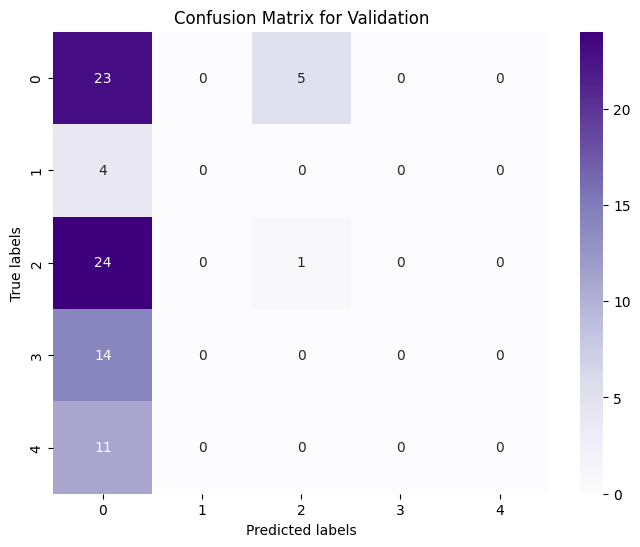

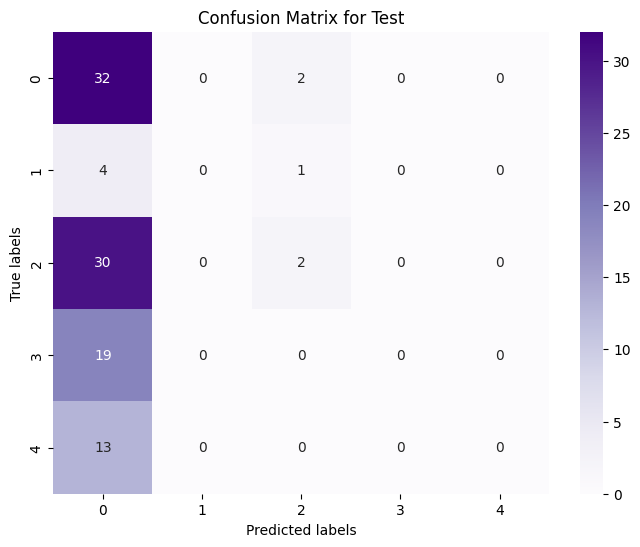

test_accuracy,33.00971
val_accuracy,29.26829


wandb: Agent Starting Run: tud7fvjx with config:
wandb: 	batch_size: 64
wandb: 	kernel_size: 2
wandb: 	learning_rate: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/usr4/ba820/pmpatel/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [1/10], Loss: 1.0385, Accuracy: 38.37%
Epoch [2/10], Loss: 0.6524, Accuracy: 60.42%
Epoch [3/10], Loss: 0.6618, Accuracy: 55.89%
Epoch [4/10], Loss: 0.5467, Accuracy: 83.08%
Epoch [5/10], Loss: 0.5059, Accuracy: 75.83%
Epoch [6/10], Loss: 0.4391, Accuracy: 96.07%
Epoch [7/10], Loss: 0.3750, Accuracy: 91.84%
Epoch [8/10], Loss: 0.3556, Accuracy: 89.43%
Epoch [9/10], Loss: 0.3040, Accuracy: 96.37%
Epoch [10/10], Loss: 0.2480, Accuracy: 99.09%
Validation Accuracy: 36.59%
Test Accuracy: 36.89%


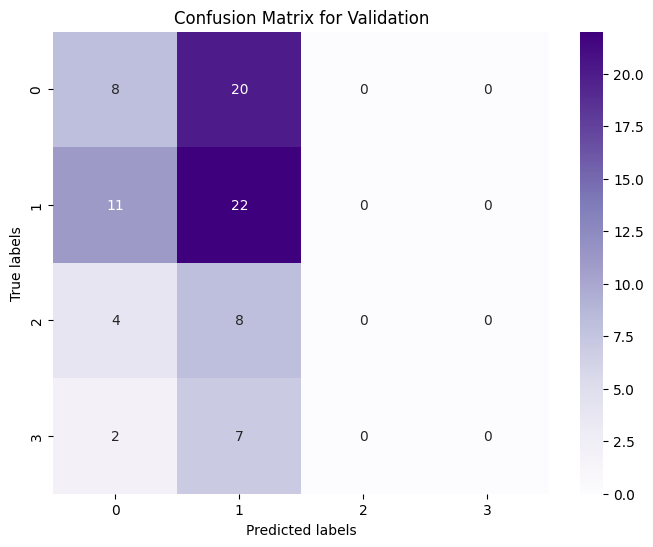

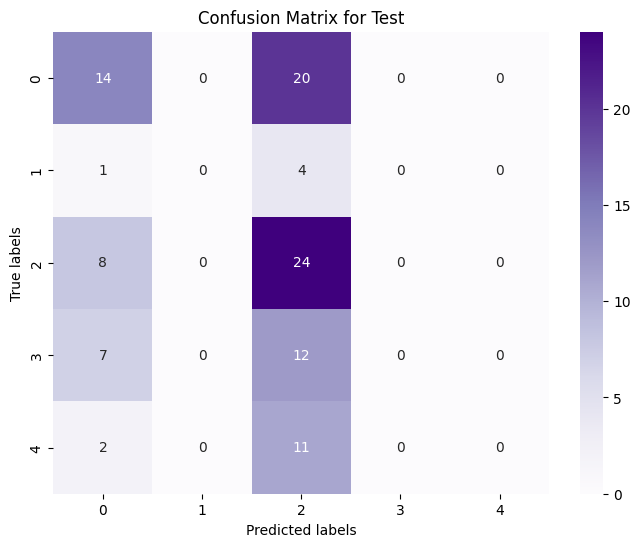

test_accuracy,36.8932
val_accuracy,36.58537


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mhfrcjkt with config:
wandb: 	batch_size: 64
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/usr4/ba820/pmpatel/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [1/10], Loss: 7.9551, Accuracy: 59.82%


In [ ]:
## Class imbalance sweeps


# batch_size": {"values": [32, 15]},
# "learning_rate": {"values": [1e-2, 1e-3, 1e-4]},
# 'kernel_size': {'values': [2, 3, 4]}

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


# Initialize WandB
wandb.login()

# Define sweep configuration
sweep_configuration = {
    "method": "grid",
    "name": "Class_imb",
    "metric": {"goal": "maximize", "name": "val_acc"},
    "parameters": {
        "batch_size": {"values": [64, 32, 15]},
        "learning_rate": {"values": [1e-3, 1e-4]},
        'kernel_size': {'values': [2, 3, 4]}
    }
}

# Main function to run a single experiment
def main():
    run = wandb.init()

    # Load data
    training_path = "Disease Grading/1. Original Images/a. Training Directory"
    testing_path = "Disease Grading/1. Original Images/b. Testing Directory"

    # Define transforms for training and augmentation
    transform_train = transforms.Compose([
        transforms.Resize((448, 600)),  # Resize images to a fixed size
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
    ])

    # No augmentation for validation and test sets
    transform_val_test = transforms.Compose([
        transforms.Resize((448, 600)),
        transforms.ToTensor(),
    ])

    # Class weights for the dataset
    class_weights = [0.324455, 0.048426, 0.329298, 0.179177, 0.118644]

    train_dataset = torchvision.datasets.ImageFolder(training_path, transform=transform_train)
    train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2])
    test_dataset = torchvision.datasets.ImageFolder(testing_path, transform=transform_val_test)

    # Data loaders
    sampler = WeightedRandomSampler(weights=class_weights, num_samples=len(train_dataset), replacement=True)

    # DataLoader for training and validation
    train_loader = DataLoader(train_dataset, batch_size=run.config.batch_size, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=run.config.batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=run.config.batch_size, shuffle=False)

    
    # Define the CNN model
    class CNN(nn.Module):
        def __init__(self, kernel_size, output_size):
            super(CNN, self).__init__()
            self.model = nn.Sequential(
                nn.Conv2d(3, 4, kernel_size),
                nn.ReLU(),
                nn.Conv2d(4, 8, kernel_size),
                nn.ReLU(),
                nn.Conv2d(8, 16, kernel_size),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(16, 32, kernel_size),
                nn.MaxPool2d(2),
                nn.Flatten(),
                nn.LazyLinear(output_size) 
            )

        def forward(self, x):
            return self.model(x)
    
    
    # Initialize model
    model = CNN(run.config.kernel_size, 5)

    # Training the model
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=run.config.learning_rate)
    num_epochs = 10
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct_train / total_train
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Evaluate the model on validation set
    model.eval()
    correct_val = 0
    total_val = 0
    val_preds = []
    val_targets = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            val_preds.extend(predicted.tolist())
            val_targets.extend(labels.tolist())
    val_accuracy = 100 * correct_val / total_val
    print('Validation Accuracy: {:.2f}%'.format(val_accuracy))

    # Log validation accuracy
    wandb.run.summary["val_accuracy"] = val_accuracy

    # Evaluate the model on test set
    correct_test = 0
    total_test = 0
    test_preds = []
    test_targets = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            test_preds.extend(predicted.tolist())
            test_targets.extend(labels.tolist())
    test_accuracy = 100 * correct_test / total_test
    print('Test Accuracy: {:.2f}%'.format(test_accuracy))

    # Log test accuracy
    wandb.run.summary["test_accuracy"] = test_accuracy

    # Confusion matrix for validation set
    val_conf_matrix = confusion_matrix(val_targets, val_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(val_conf_matrix, annot=True, fmt="d", cmap="Purples")
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix for Validation")
    plt.show()

    # Confusion matrix for test set
    test_conf_matrix = confusion_matrix(test_targets, test_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Purples")
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix for Test")
    plt.show()


# Initialize sweep
sweep_id = wandb.sweep(sweep=sweep_configuration, project='grp4_class_imb')

# Start sweep job
wandb.agent(sweep_id, function=main)
